In [1]:
# Import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from itertools import combinations
import statsmodels.api as sm

In [2]:
# Load training and testing data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df = train_df.drop(columns=['Id'])
test_df = test_df.drop(columns=['Id'])

print(train_df["SalePrice"].mean())
# Preview the data
print(train_df.head())
print(train_df.info())


180921.19589041095
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD      

In [3]:
# Check for missing values in each column
missing_data = train_df.isnull().sum()
missing_data_test = test_df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_data_test = missing_data_test[missing_data_test > 0].sort_values(ascending=False)

print(missing_data)
print(missing_data_test)

# deletes columns that are missing data based on missing threshold
# if threshold is 0.3, it removes data that has more than 30% missing
##threshold = 0.5
##missing_percentage = train_df.isnull().mean()
##cols_to_drop = missing_percentage[missing_percentage > threshold].index
##train_df.drop(columns=cols_to_drop, inplace=True)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
KitchenQual        1
BsmtUnfSF          1


In [4]:
## uncomment out the """""" if we do not want to remove data and instead replace with "none"

# Filling columns with "None" in train and test data
# This is because these features are missing in >90% or around 90% of data samples
for col in ["PoolQC", "MiscFeature", "Alley", "Fence"] :
    train_df[col] = train_df[col].fillna("None")
    test_df[col] = test_df[col].fillna("None")

# Fill other missing values as described
# MasVnrType and MasVnrArea: Likely represent masonry veneer details, which might be absent in some properties.
# FireplaceQu: Quality of fireplace. Missing values might mean the absence of a fireplace.
# LotFrontage: This is numerical and represents the frontage area. We could use the median.
train_df["MasVnrType"] = train_df["MasVnrType"].fillna("None")
test_df["MasVnrType"] = test_df["MasVnrType"].fillna("None")

# only 8 values are missing for MasVnrArea, so I will fill it in with the median
# its possible these values are missing due to missing MasVnr, in this case change it to this:
"""
train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(0)
test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna(0)
"""

# the above will fill it with values of 0 instead of the median
train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(train_df["MasVnrArea"].mean())
test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna(test_df["MasVnrArea"].mean())

train_df["FireplaceQu"] = train_df["FireplaceQu"].fillna("None")
test_df["FireplaceQu"] = test_df["FireplaceQu"].fillna("None")

# LotFrontage with median
train_df["LotFrontage"] = train_df["LotFrontage"].fillna(train_df["LotFrontage"].mean())
test_df["LotFrontage"] = test_df["LotFrontage"].fillna(test_df["LotFrontage"].mean())

# Garage columns
# Missing values are probably due to the fact that these buildings do not have a garage
garage_cols = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
for col in garage_cols:
    train_df[col] = train_df[col].fillna("None")
    test_df[col] = test_df[col].fillna("None")

# If they don't have a garage, replace with 0 yr built; if this is a problem later fix it to 1900
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].fillna(train_df["GarageYrBlt"].mean())
test_df["GarageYrBlt"] = test_df["GarageYrBlt"].fillna(train_df["GarageYrBlt"].mean())

# Basement columns
# Missing values probably means that there is no basement
bsmt_cols = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
for col in bsmt_cols:
    train_df[col] = train_df[col].fillna("None")
    test_df[col] = test_df[col].fillna("None")

test_missing_cols = ["MSZoning", "Utilities", "BsmtFullBath", "Functional", "Exterior1st", "Exterior2nd", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"
                     , "KitchenQual", "GarageCars", "GarageArea", "SaleType", "BsmtHalfBath"]
for col in test_missing_cols:
    train_df[col] = train_df[col].fillna(test_df[col].mode()[0])
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])
# Electrical with mode
# Only one missing value, we can just find the most common (mode) and fill it in
train_df["Electrical"] = train_df["Electrical"].fillna(train_df["Electrical"].mode()[0])
test_df["Electrical"] = test_df["Electrical"].fillna(test_df["Electrical"].mode()[0])



In [5]:
# Check for missing values in each column
missing_data = train_df.isnull().sum()
missing_data_test = test_df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_data_test = missing_data_test[missing_data_test > 0].sort_values(ascending=False)

print(missing_data)
print(missing_data_test)


Series([], dtype: int64)
Series([], dtype: int64)


In [6]:
# Here is part 2 of the preprocessing, converting the data labels into one-hot encoding
# how it works is: 1. finds the categorical columns, 2. It creates columns for feature variable types
# for example, for Color, it'll make Color_red, Color_green, Color_blue columns and give boolean values
# to them. That's basically how one-hot encoding works (I think)

# Identify categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols)

# Apply One-Hot Encoding to both train and test sets
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

# Align columns in train and test sets
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

# Verify encoding shape size
print("Training data shape after encoding:", train_df.shape)
print("Test data shape after encoding:", test_df.shape)

# Just to check the first few data samples to see if it worked
print(train_df.head())


Categorical columns: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Training data shape after encoding: (1460, 303)
Test data shape after encoding: (1459, 303)
   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       19

In [7]:

# Get the feature names (columns) in train_df
original_features = train_df.columns.tolist()

# Initialize an empty dictionary to store interaction columns for train_df
interaction_data_train = {}
interaction_data_test = {}

# Create interaction terms and add to the interaction data dictionaries
for feature1, feature2 in combinations(original_features, 2):
    interaction_column_name = f"{feature1}_x_{feature2}"
    interaction_data_train[interaction_column_name] = train_df[feature1] * train_df[feature2]
    interaction_data_test[interaction_column_name] = test_df[feature1] * test_df[feature2]

# Convert the interaction dictionaries to DataFrames
interaction_df_train = pd.DataFrame(interaction_data_train)
interaction_df_test = pd.DataFrame(interaction_data_test)

# Concatenate the interaction DataFrames with the original DataFrames
train_df = pd.concat([train_df, interaction_df_train], axis=1)
test_df = pd.concat([test_df, interaction_df_test], axis=1)


In [8]:
# Standardizing the data

# Get the numerical columns from the DataFrame
# Find all the data types that include ints and floats and use their columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

mean = train_df[numerical_cols].mean()
std = train_df[numerical_cols].std()

train_df[numerical_cols] = (train_df[numerical_cols] - mean) / std
test_df[numerical_cols] = (test_df[numerical_cols] - mean) / std  # Use train mean and std

print(train_df.shape)
print(test_df.shape)

(1460, 46056)
(1459, 46056)


In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso

def select_features_with_rfe(X, y, step, n_features_to_select=5):
    """
    Perform Recursive Feature Elimination (RFE) to select the top features.

    Args:
        X (pd.DataFrame): DataFrame containing the features.
        y (pd.Series): Target variable.
        n_features_to_select (int): Number of features to select.

    Returns:
        list: List of selected feature names.
    """
    # Define the model
    model = Lasso(alpha=0.01)  # You can tune the alpha value

    # Initialize RFE with the specified number of features to select
    rfe = RFE(estimator=model, step=step, n_features_to_select=n_features_to_select)

    # Fit RFE
    rfe.fit(X, y)

    # Get the selected feature names
    selected_features = X.columns[rfe.support_].tolist()

    return selected_features


In [10]:
# Min-Max Scaling
min_vals = train_df[numerical_cols].min()
max_vals = train_df[numerical_cols].max()

train_df[numerical_cols] = (train_df[numerical_cols] - min_vals) / (max_vals - min_vals)
test_df[numerical_cols] = (test_df[numerical_cols] - min_vals) / (max_vals - min_vals)  # Use train min and max

# Log Transformation (adding a small constant to avoid log(0))
train_df[numerical_cols] = np.log1p(train_df[numerical_cols])
test_df[numerical_cols] = np.log1p(test_df[numerical_cols])

train_df = train_df.dropna(axis=1, how='all')
test_df = test_df.dropna(axis=1, how='all')

# Check for and drop any non-numeric columns
train_df_numeric = train_df.select_dtypes(include=[np.number])

# Drop rows or columns with missing values (or impute if needed)
train_df_numeric = train_df_numeric.dropna()

In [11]:
# Define your target (ensure it's aligned with the cleaned DataFrame)
target = train_df_numeric["SalePrice"]
features = train_df_numeric.drop(columns=["SalePrice"])

selected_features = select_features_with_rfe(features, target, step=25, n_features_to_select = 775)

selected_features_with_target = selected_features + ["SalePrice"]

# Filter train_df and test_df to keep only the selected features
train_df_selected = train_df[selected_features_with_target]  # Keep target in training set
test_df_selected = test_df[selected_features]  # Exclude target from test set

print("Filtered train_df shape:", train_df_selected.shape)
print("Filtered test_df shape:", test_df_selected.shape)

Filtered train_df shape: (1460, 776)
Filtered test_df shape: (1459, 775)


In [12]:
"""
# Handeling outliers
Q1 = train_df[numerical_cols].quantile(0.25)
Q3 = train_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Cap outliers
train_df[numerical_cols] = np.where(train_df[numerical_cols] < (Q1 - 1.5 * IQR), (Q1 - 1.5 * IQR),
                                     np.where(train_df[numerical_cols] > (Q3 + 1.5 * IQR), (Q3 + 1.5 * IQR),
                                              train_df[numerical_cols]))
test_df[numerical_cols] = np.where(test_df[numerical_cols] < (Q1 - 1.5 * IQR), (Q1 - 1.5 * IQR),
                                     np.where(test_df[numerical_cols] > (Q3 + 1.5 * IQR), (Q3 + 1.5 * IQR),
                                              test_df[numerical_cols]))

# Assuming train_df is your DataFrame
print("Size of the DataFrame (rows, columns):", train_df.shape)

"""

'\n# Handeling outliers\nQ1 = train_df[numerical_cols].quantile(0.25)\nQ3 = train_df[numerical_cols].quantile(0.75)\nIQR = Q3 - Q1\n\n# Cap outliers\ntrain_df[numerical_cols] = np.where(train_df[numerical_cols] < (Q1 - 1.5 * IQR), (Q1 - 1.5 * IQR),\n                                     np.where(train_df[numerical_cols] > (Q3 + 1.5 * IQR), (Q3 + 1.5 * IQR),\n                                              train_df[numerical_cols]))\ntest_df[numerical_cols] = np.where(test_df[numerical_cols] < (Q1 - 1.5 * IQR), (Q1 - 1.5 * IQR),\n                                     np.where(test_df[numerical_cols] > (Q3 + 1.5 * IQR), (Q3 + 1.5 * IQR),\n                                              test_df[numerical_cols]))\n\n# Assuming train_df is your DataFrame\nprint("Size of the DataFrame (rows, columns):", train_df.shape)\n\n'

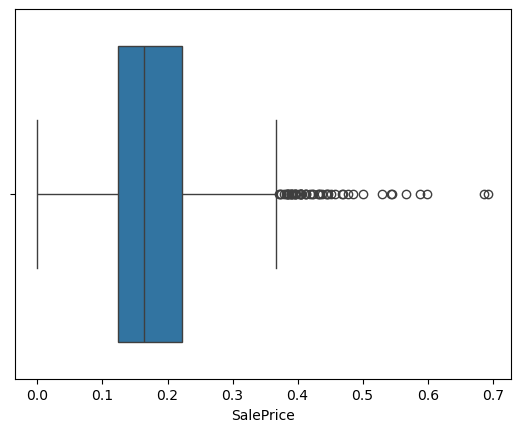

In [13]:
# kinda irrelevant if we are not removing outliers, but its here to visualize the distribution of prices
sns.boxplot(x=train_df['SalePrice'])
plt.show()

In [14]:
# Assuming your features are stored in X and target in y
X = train_df_selected.drop(columns=['SalePrice'])
y = train_df_selected['SalePrice']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state=42)

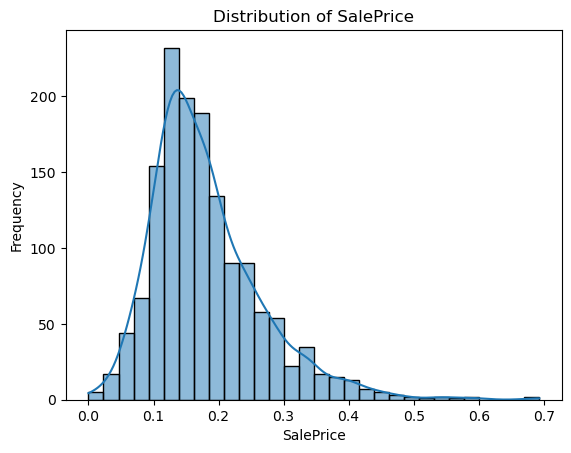

In [15]:
# Visualize the distribution of SalePrice
sns.histplot(train_df['SalePrice'], bins=30, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

## Linear Regression

In [16]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

LinearRegression()

Train RMSE: 3.1196345446787716e-05


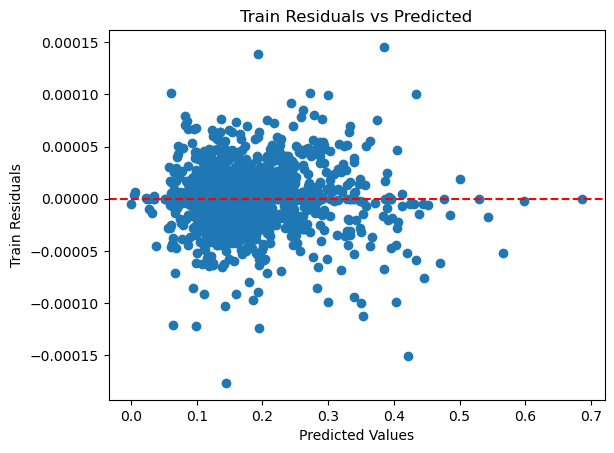

In [17]:
# Make predictions
y_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Train RMSE: {rmse}')

# Plotting residuals
y_pred_train = model.predict(X_train)
residuals = y_train - y_pred_train

plt.scatter(y_pred_train, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Train Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Train Residuals')
plt.show()

Test RMSE: 0.0011290885625746877


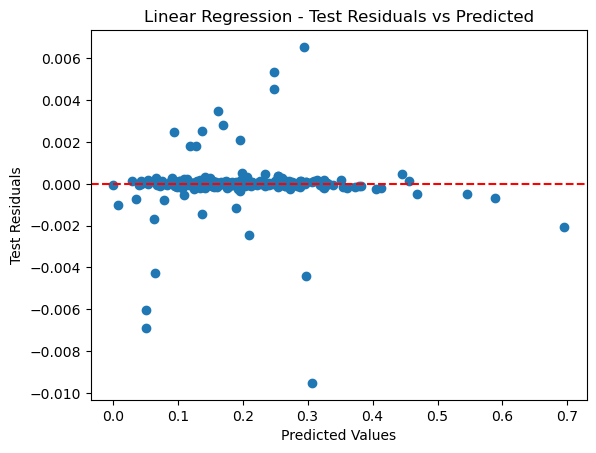

In [18]:
"""
# Check for correlations
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
"""
# Make predictions
y_pred = model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Test RMSE: {rmse}')

# Plotting residuals
y_pred_val = model.predict(X_val)
residuals = y_val - y_pred_val

plt.scatter(y_pred_val, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Linear Regression - Test Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Test Residuals')
plt.show()


## Lasso Regression

In [19]:
from sklearn.linear_model import LassoCV

In [20]:
# Create a ridge regression model
model = LassoCV()

# Train the model
model.fit(X_train, y_train)

LassoCV()

Train RMSE: 0.001046564554413271


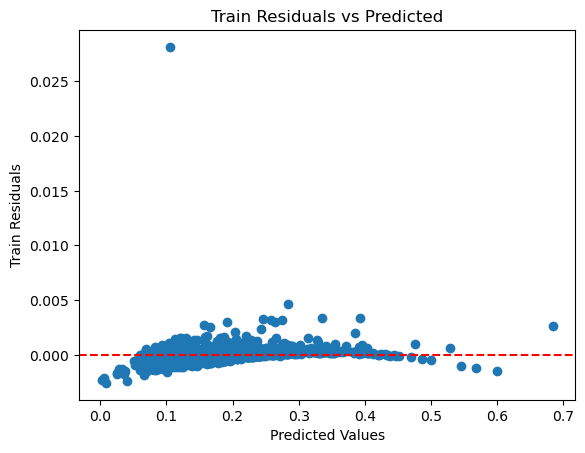

In [21]:
# Make predictions
y_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Train RMSE: {rmse}')

# Plotting residuals
y_pred_train = model.predict(X_train)
residuals = y_train - y_pred_train

plt.scatter(y_pred_train, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Train Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Train Residuals')
plt.show()

Test RMSE: 0.0006459014425931874


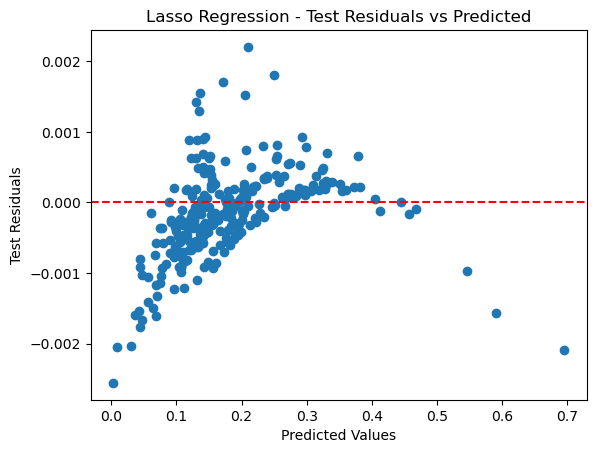

In [22]:
# Make predictions
y_pred = model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Test RMSE: {rmse}')

# Plotting residuals
y_pred_val = model.predict(X_val)
residuals = y_val - y_pred_val

plt.scatter(y_pred_val, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Lasso Regression - Test Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Test Residuals')
plt.show()

## Ridge Regression

In [23]:
from sklearn.linear_model import RidgeCV

In [24]:
# Create a ridge regression model
model = RidgeCV()

# Train the model
model.fit(X_train, y_train)

RidgeCV()

Train RMSE: 0.0005181842181994672


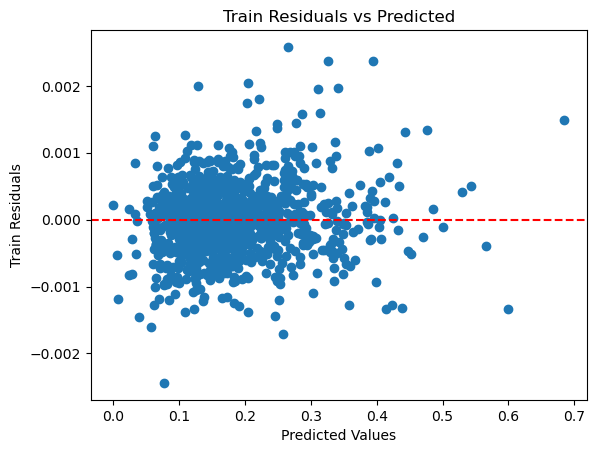

In [25]:
# Make predictions
y_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Train RMSE: {rmse}')

# Plotting residuals
y_pred_train = model.predict(X_train)
residuals = y_train - y_pred_train

plt.scatter(y_pred_train, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Train Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Train Residuals')
plt.show()

Test RMSE: 0.0012999790189735195


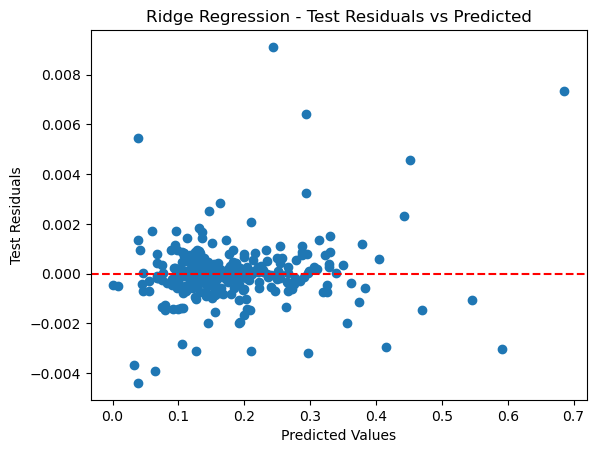

In [26]:
# Make predictions
y_pred = model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Test RMSE: {rmse}')

# Plotting residuals
y_pred_val = model.predict(X_val)
residuals = y_val - y_pred_val

plt.scatter(y_pred_val, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Ridge Regression - Test Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Test Residuals')
plt.show()

## Elastic Net

In [27]:
from sklearn.linear_model import ElasticNetCV

In [28]:
# Create a ridge regression model
model = ElasticNetCV()

# Train the model
model.fit(X_train, y_train)

ElasticNetCV()

Train RMSE: 0.0016988500975922316


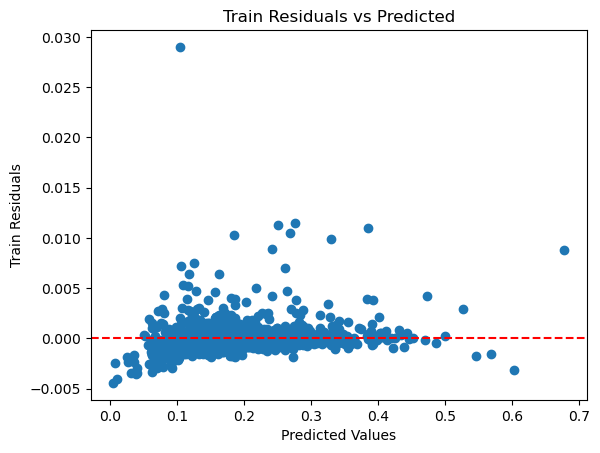

In [29]:
# Make predictions
y_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Train RMSE: {rmse}')

# Plotting residuals
y_pred_train = model.predict(X_train)
residuals = y_train - y_pred_train

plt.scatter(y_pred_train, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Train Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Train Residuals')
plt.show()

Test RMSE: 0.0012037090946124512


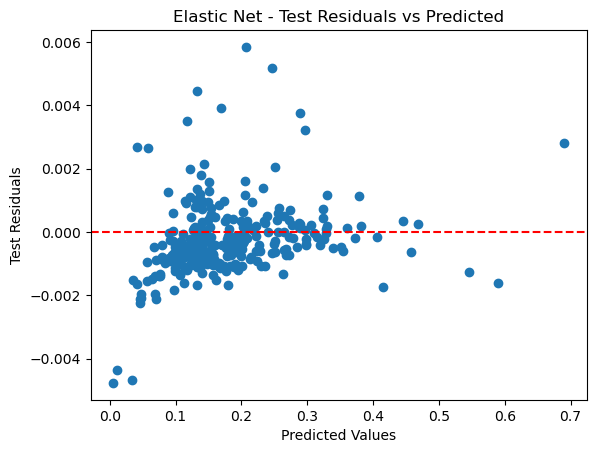

In [30]:
# Make predictions
y_pred = model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Test RMSE: {rmse}')

# Plotting residuals
y_pred_val = model.predict(X_val)
residuals = y_val - y_pred_val

plt.scatter(y_pred_val, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Elastic Net - Test Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Test Residuals')
plt.show()

## Linear SVR

In [31]:
from sklearn.svm import LinearSVR

In [32]:
# Create a ridge regression model
model = LinearSVR()

# Train the model
model.fit(X_train, y_train)

/Users/jo/miniconda3/envs/group96/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR()

Train RMSE: 0.00022277118493247398


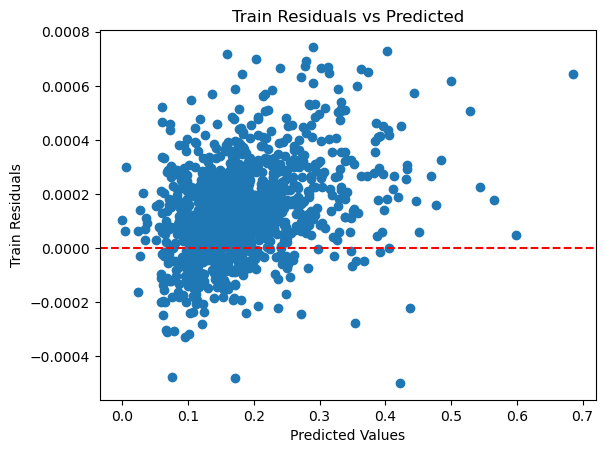

In [33]:
# Make predictions
y_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Train RMSE: {rmse}')

# Plotting residuals
y_pred_train = model.predict(X_train)
residuals = y_train - y_pred_train

plt.scatter(y_pred_train, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Train Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Train Residuals')
plt.show()

Test RMSE: 0.0009052108067539621


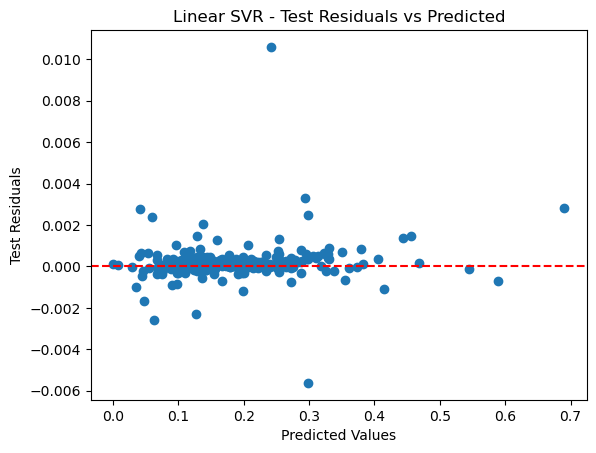

In [34]:
# Make predictions
y_pred = model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f'Test RMSE: {rmse}')

# Plotting residuals
y_pred_val = model.predict(X_val)
residuals = y_val - y_pred_val

plt.scatter(y_pred_val, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Linear SVR - Test Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Test Residuals')
plt.show()